In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
# Срез количества дней для тестовой выборки
maxForecastDays = 5

In [3]:
# Вычисление метрик качества прогнозов
def Metrics(y, y_pred):
    
    mse = round(mean_squared_error(y, y_pred), 4)
    mae = round(mean_absolute_error(y, y_pred), 4)
    mape = round(mean_absolute_percentage_error(y, y_pred), 4)
    R2 = round(r2_score(y, y_pred), 4)
    
    return [mse, mae, mape, R2]

# Формирование таблицы метрик на тренировочной и тестовой выборке
def MetricsDF(model, x_train, x_valid, y_train, y_valid, tableName = 'Errors', testUsed = False, x_test = [], y_test = [], plot = False, savePath = ''):
    
    resDf = pd.DataFrame(index=['MSE', 'MAE', 'MAPE', 'R2'], data = 
                             {'Train': Metrics(y_train, model.predict(x_train)),
                             'Valid': Metrics(y_valid, model.predict(x_valid))})
    if testUsed:
        resDf['Test'] = Metrics(y_test, model.predict(x_test))
                        
    resDf.index.name = tableName
    display(resDf)
    
    
    if plot:
        x_valid.sort_index(inplace = True)
        y_valid.sort_index(inplace = True)
        CompareGraph(y_valid.index, y_valid, model.predict(x_valid), 'Истинные значения', 'Прогнозируемые значения', 'Сравнение прогноза с истинными данными. Valid')
        if testUsed:
            x_test.sort_index(inplace = True)
            y_test.sort_index(inplace = True)
            CompareGraph(y_test.index, y_test, model.predict(x_test), 'Истинные значения', 'Прогнозируемые значения', 'Сравнение прогноза с истинными данными. Test')
    
    # Сохранение в файл
    if savePath:
        sheet_name = f'est = {model.n_estimators}, smpl =  {model.min_samples_split}'
        
        # Номер последней строки в файле
        numRow = 0
        wb = load_workbook(savePath)
        if sheet_name in wb.sheetnames:
            numRow = wb[sheet_name].max_row + 2
        
        with pd.ExcelWriter(savePath, engine="openpyxl", mode = 'a', if_sheet_exists='overlay') as writer:
            resDf.to_excel(writer, sheet_name = sheet_name, startrow = numRow)

# Сравнение графиков двух списков значений
def CompareGraph(x, y1, y2, l1, l2, title):
    plt.figure(figsize = (10, 4))
    plt.plot(x, y1, label = l1)
    plt.plot(x, y2, label = l2)

    plt.xlabel('time')
    plt.ylabel('PM 2.5, мкг/м³')
    plt.title(title)
    
    plt.legend()
    plt.grid()
    
    plt.show()
    
# Разделение данных по сезонам
def splitDataBySeason(df, season):
    # Зима
    if season == 'winters':
        win19 = df[:'2019-03-01 00:00:00']
        win19_20 = df['2019-11-27 00:00:00':'2020-02-27 00:00:00']
        win20_21 = df['2020-11-27 00:00:00':'2021-02-25 00:00:00']
        win21_22 = df['2021-12-15 00:00:00':'2022-02-22 00:00:00']
        win22_23 = df['2022-12-13 00:00:00' : '2023-02-22 00:00:00']

        return pd.concat([win19, win19_20, win20_21, win21_22, win22_23])
    
    # Весна
    if season == 'springs':
        spr19 = pd.concat([df['2019-03-10' : '2019-05-01'], df['2019-11-01' : '2019-11-22']])
        spr20 = pd.concat([df['2020-03-01' : '2020-05-01'], df['2020-11-01' : '2020-11-10']])
        spr21 = pd.concat([df['2021-03-10' : '2021-05-01'], df['2021-11-01' : '2021-11-25']])
        spr22 = pd.concat([df['2022-03-01' : '2022-05-01'], df['2022-11-01' : '2022-11-25']])
        spr23 = df['2023-03-01' : ]

        return pd.concat([spr19, spr20, spr21, spr22, spr23])

    # Лето
    if season == 'summers':
        sum19 = df['2019-05-01' : '2019-07-12']
        sum20 = df['2020-05-01' : '2020-08-01']
        sum21 = df['2021-05-01' : '2021-08-01']
        sum22 = df['2022-05-01' : '2022-08-01']

        return pd.concat([sum19, sum20, sum21, sum22])
    
    # Осень
    if season == 'autumns':
        aut19 = df['2019-08-21' : '2019-10-16']
        aut20 = df['2020-08-17' : '2020-10-30']
        aut21 = df['2021-08-15' : '2021-11-01']
        aut22 = df['2022-08-01' : '2022-10-14']

        return pd.concat([aut19, aut20, aut21, aut22])
    

In [4]:
# Прогнозирование при помощи случайного леса
def RandForestForecast(sensor, fill, district, begin, end, season = '', forecastDays = 0, valid_size = 0.3, test_index = [], estNum = 100, min_samples_split = 5, max_depth = None, plotRes = False, featImp = False,
                       path = '../data/', savePath = ''):
    
    # Данные pm 
    df = pd.read_csv(f"{path}pm25_{sensor}{fill}.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'], usecols = ['Date', district])
    df.rename(columns = {district : 'pm'}, inplace = True)

    # Исключение выборки прогнозирования
    df.drop(index = [f'2023-02-{i}' for i in range(18, 23)] + [f'2023-03-{i}' for i in range(23, 28)] +
                    [f'2022-07-{i}' for i in range(28, 32)] + [f'2022-08-01'] +
                     [f'2022-10-{i}' for i in range(10, 15)], inplace = True)
        
    
    features = ['Pressure', 'Temperature', 'Wet', 'Wind_dir', 'Wind_speed']
    for feat in features:
        df[feat] = pd.read_csv(f"{path}Features{fill}/{feat}_{sensor}.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'], usecols = ['Date', district])

        # Проверка на пропуски
        nans = pd.isnull(df[begin : end].values).sum()
             
        if nans > 0:
            print(f'Пропуски в {feat} :', nans)
 
    
    # Добавление инверсий
    inversions = pd.read_csv(f"{path}Inversions.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'])
        
    df = inversions.join(df)    
    
    
    df.dropna(inplace = True)
    
    
    testUsed = False
    # Формирование тестовой выборки
    if len(test_index):
        testUsed = True
        test_index = list(set(pd.to_datetime(test_index)) & set(df.index))
        x_test = df.loc[test_index].drop(['pm'], axis = 1)
        y_test = df.loc[test_index]['pm']
        df.drop(test_index, inplace = True)
    
    df = df[begin : end]
    
    
    tableName = f'{min(df.index.date)} — {max(df.index.date)}'
    
    
    # Срез для выбранного сезона
    if season:
        df = splitDataBySeason(df, season)
    
    # Срез данных для прогнозирования
   
    '''if forecastDays:
        testUsed = True
        x_forecast = df.iloc[-maxForecastDays: df.shape[0] - maxForecastDays + forecastDays].drop(['pm'], axis = 1)
        y_forecast = df.iloc[-maxForecastDays: df.shape[0] - maxForecastDays + forecastDays]['pm']'''
    
    
    df = df.iloc[:-maxForecastDays]
    
    
    # Разбиение данных
    x = df.drop(['pm'], axis = 1)
    y = df['pm']
    
    # train : valid выборки 70 : 30
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = valid_size, random_state=1)

    
    # Создаем модель
    rf = RandomForestRegressor(n_estimators = estNum, n_jobs=-1, random_state = 100, min_samples_split = min_samples_split, max_depth = max_depth)
    # Обучаем
    rf.fit(x_train, y_train)

    if testUsed:
        MetricsDF(rf, x_train, x_valid, y_train, y_valid, tableName, testUsed, x_test, y_test, plotRes, savePath)
    else:
        MetricsDF(rf, x_train, x_valid, y_train, y_valid, tableName, testUsed, plotRes, savePath)
    
    # Определение важности признаков
    if featImp: FeatureImportance(x, rf)
    
# Важность признаков
def FeatureImportance(data, model):
    # Упорядычиваем наши фичи по значениям весов, от самой полезной к самой бесполезной
    df_importances= sorted(list(zip(data.columns, model.feature_importances_.ravel())), key=lambda tpl: tpl[1], reverse=True)

    # Создаем табличку, в которой будет показан признак и его вес
    df_importances = pd.DataFrame(df_importances, columns=['feature', 'importance']) 

    # Нумируем колонки, чтобы не путать их
    df_importances = df_importances.set_index('feature')

    # Создаем график, чтобы было нагляднее
    df_importances.plot(kind='bar', figsize=(8, 3))

    plt.title('Важность признаков')
    # Рисуем график
    plt.show()

    # Таблица с важностью признаков
    display(df_importances)

In [5]:
sensor = 's'
fill = '_fill'

district = 'Mean'

# Срез данных от begin до end
begin, end = '2020-01-01', '2023-04-06'


#savePath = 'Results/Results RF large periods.xlsx'

In [10]:
for season in ['winters', 'springs', 'summers', 'autumns']:
    
    test_index = pd.read_csv(f"../data/test_index.csv", sep = ';', dayfirst=True, parse_dates = [season])[season].values
    RandForestForecast(sensor, fill, district, begin, end, season = '', forecastDays = 0, valid_size = 0.3, test_index = test_index, estNum = 100, plotRes = False, featImp = False)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2020-01-01 — 2023-03-22,,,
MSE,39.5493,206.0350,429.9846
MAE,3.4945,7.8508,15.2985
MAPE,0.2288,0.4875,0.4480
R2,0.9510,0.7762,0.6768


Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2020-01-01 — 2023-03-22,,,
MSE,43.1349,194.9346,51.6995
MAE,3.6504,8.0308,5.8276
MAPE,0.2243,0.5041,0.5379
R2,0.9482,0.8085,0.4634


Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2020-01-01 — 2023-03-22,,,
MSE,44.7177,205.4797,39.5734
MAE,3.7885,8.0179,4.8005
MAPE,0.2332,0.5131,0.6587
R2,0.9445,0.8084,0.1878


Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2020-01-01 — 2023-03-22,,,
MSE,50.3787,179.7600,29.9065
MAE,3.7802,8.2374,4.0701
MAPE,0.2334,0.5195,0.5732
R2,0.9400,0.8191,0.3289


In [25]:
season = 'autumns'

In [26]:
test_index = pd.read_csv(f"../data/test_index.csv", sep = ';', dayfirst=True, parse_dates = [season])[season].values

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2020-01-01 — 2023-03-22,,,
MSE,4.6293,39.7584,30.3840
MAE,1.5151,4.0717,4.2410
MAPE,0.2023,0.4179,0.5935
R2,0.9224,0.5355,0.3181


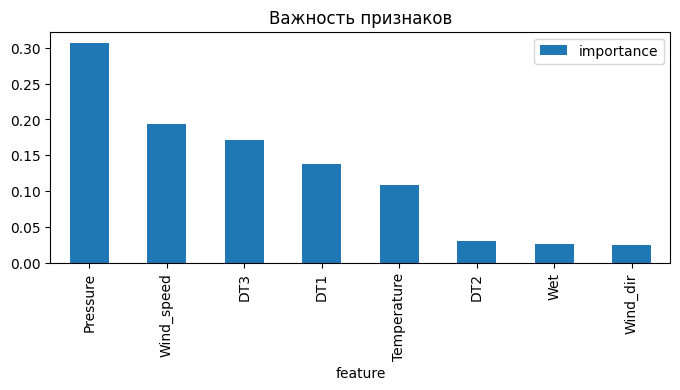

,importance
feature,
Pressure,0.307359
Wind_speed,0.193852
DT3,0.171628
DT1,0.137931
Temperature,0.108868
DT2,0.030367
Wet,0.025313
Wind_dir,0.024683


In [27]:
RandForestForecast(sensor, fill, district, begin, end, season = season, forecastDays = 0, valid_size = 0.4, test_index = test_index, estNum = 1000, plotRes = False, featImp = True)

### Зима

In [23]:
season = 'winters'

In [24]:
RandForestForecast(sensor, fill, district, begin, end, season, forecastDays = 0, valid_size = 0.3, test_index = test_index, estNum = 1000, plotRes = False, featImp = False)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22,,,
MSE,114.5737,540.2146,486.9905
MAE,7.1014,15.9620,16.4746
MAPE,0.2001,0.5269,0.5120
R2,0.9480,0.6457,0.6339


In [25]:
RandForestForecast(sensor, fill, district, begin, end, season, forecastDays = 0, valid_size = 0.35, test_index = test_index, estNum = 100, plotRes = False, featImp = False)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22,,,
MSE,123.4645,519.5350,507.1345
MAE,7.2549,15.8669,16.4940
MAPE,0.2060,0.5371,0.5452
R2,0.9445,0.6701,0.6188


### Весна

In [26]:
season = 'springs'

In [28]:
RandForestForecast(sensor, fill, district, begin, end, season, forecastDays = 0, valid_size = 0.3, test_index = test_index, estNum = 1000, plotRes = False, featImp = False)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22,,,
MSE,9.3392,52.9227,36.8554
MAE,2.1326,5.5546,4.3515
MAPE,0.1685,0.4547,0.3565
R2,0.9235,0.5674,0.6175


In [29]:
RandForestForecast(sensor, fill, district, begin, end, season, forecastDays = 0, valid_size = 0.4, test_index = test_index, estNum = 1000, plotRes = False, featImp = False)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22,,,
MSE,9.2797,51.1717,38.9986
MAE,2.2123,5.2086,4.4075
MAPE,0.1714,0.4509,0.3672
R2,0.9293,0.5347,0.5952


### Лето

In [30]:
season = 'summers'

In [32]:
RandForestForecast(sensor, fill, district, begin, end, season, forecastDays = 0, valid_size = 0.3, test_index = test_index, estNum = 1000, plotRes = False, featImp = False)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22,,,
MSE,6.1772,20.6212,28.5950
MAE,1.5126,3.3820,4.1808
MAPE,0.1876,0.4457,0.5028
R2,0.8330,0.3286,0.4131


In [33]:
RandForestForecast(sensor, fill, district, begin, end, season, forecastDays = 0, valid_size = 0.4, test_index = test_index, estNum = 1000, plotRes = False, featImp = False)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22,,,
MSE,6.7960,21.3095,30.7716
MAE,1.5842,3.4718,4.2567
MAPE,0.2022,0.4706,0.5005
R2,0.8142,0.3489,0.3684


### Осень

In [34]:
season = 'autumns'

In [36]:
RandForestForecast(sensor, fill, district, begin, end, season, forecastDays = 0, valid_size = 0.3, test_index = test_index, estNum = 1000, plotRes = False, featImp = False)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22,,,
MSE,6.3065,27.2117,19.2436
MAE,1.5489,3.6020,3.4579
MAPE,0.1736,0.4738,0.5275
R2,0.9078,0.3493,0.5681


In [37]:
RandForestForecast(sensor, fill, district, begin, end, season, forecastDays = 0, valid_size = 0.3, test_index = test_index, estNum = 100, plotRes = False, featImp = False)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22,,,
MSE,7.1855,27.1704,20.2328
MAE,1.5761,3.6388,3.5533
MAPE,0.1678,0.4779,0.5479
R2,0.8950,0.3503,0.5459
